## Shape: challenge for DS position
--- 

Applicant name: **Mauricio Branbilla Junior**

--- 

### Challenge description

To enable the operations of an FPSO, we use sensors to make sure the equipment does not fail. These sensors measure different parameters of the equipment in different setup configurations (preset 1 and preset 2) over time. We want you to investigate one piece of equipment in different time cycles to understand what characteristics and parameters of the sensors might indicate that the equipment is on the verge of failing. To solve this problem, we expect you to answer a few questions regarding the attached dataset:

    1 – Calculate how many times the equipment has failed.

    2 – Categorize equipment failures by setups configurations (preset 1 and preset 2).

    3 – Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others).

    4 – Create a model using the technique you think is most appropriate and measure its performance.

    5 – Analyze variable importance.



**Few Tips:**

Please write down any insights and conclusions throughout your code when you think it is necessary, keeping them as clear and complete as possible. Think of this exercise as your first technical report for Shape!
At Shape, we generally work with Python, and you are encouraged to use this language. However, if you can't use Python, you can use R or Julia for this assessment. We value clean, concise, and production-ready code.
Once you’re done, please send us your analyses and answers in an Html notebook, but also other conclusions and insights that you think are relevant to the project. We value creativity!
Feel free to discuss how you think you would put the models in production.


**What do we expect you to do:**

Present storytelling of data and analyses performed.
Problem comprehension.
Data exploration.
Logic and concise model definition.
Rationale explanation.
Results evaluation.


**What you DON'T need to do?**

Super complex models with no logic or rationale behind them.

---

### Some notes about my solution:

**What will be my approach?**

Keeping in mind the bias-variance tradeoff and the fact of the dataset has just a few predictors, I'll look for the simplest model (i.e. with the less complexity as possible) that can leads to satisfatory predictions. Given that, I'll test two models:

- (A) Logistic Regression: a linear classification model
- (B) Randon Forest: a non-linear (tree-based) classification model

The choose between these models will be done by comparing the performance metric. If the performance metrics are similar, we'll choose that have lower complexity (in this case, the Logistic Regression Model) - in other words, we just choose a more complex model if we have a realistic gain in that approach. Both of these models will give a inference of the probability of failure.

In addition to, we'll compare the results with annother approach using a survival model: 

- (C) Random Survival Forest: a non-linear (tree-based) survival model

The survival model requires two targets: one representing the _time to event_ and another representing the occurence of the event. In the provided dataset, we can calculate the time to event by counting the quantity of cicles between failures. This kind of model will give, as well as the probability of failure, a inference of how much time until the failure, and this information can be very useful for the context of planning preventive maitenances. 



**What are the performance metrics that I'll use?**

One fact about the provided dataset is that the data is **unbalanced** (about 8.25% of the data was labeled as failure). 

Looking for the costs envolved in machinary maintence and thinking about the impact of false negatives or false positives classifications at this cost:

- False positives means that the preventive maintenance may be done without needed
- False negatives means that the preventive maintenance will not be done and the equipment may presents a failure, reprensenting a corrective maintence cost - this cost tends to be significant higher than the preventive maintenance and we want to avoid that.

Given that poits, we want to be focused in reduce the false negative rate (i.e. the sensibility). Given that, the PR AUC Score (Area Under Precision-Recall Curve) might be more adequated than ROC AUC Score for this case. 

For the Survival Model, we'll also use the _Concordance Index_ (c-index) to measure the fit quality.

--- 
### <a id='index'>Table of Contents:</a>

- [1. Environment setup](#sec_1)
- [2. Data overview](#sec_2)

### <a id='sec_1'>1. Environment setup</a>

At this section:

- Set some variables with paths from current working directory
- Install and import required Python libraries
- Set some constants that will be used on the solutions 


[(back to Table of Contents)](#index)


In [9]:
# Set working directory and paths

import os

MAIN_PATH = os.getcwd()
DATA_FILE_PATH = MAIN_PATH + '/data/O_G_Equipment_Data.xlsx'

print(f"Current Path: {MAIN_PATH}")


Current Path: /Users/mbranbilla/Projects/shape_challenge


In [5]:
%%capture
# Requirements

import subprocess
import sys

requirements = """#Python 3.11.4
pandas==2.0
numpy>=1.21.0, <1.27.0, !=1.24.0
scipy==1.10
scikit-learn==1.3
matplotlib==3.7
seaborn==0.12.2
shap==0.42.1
tqdm
"""
with open('requirements.txt', 'w') as f:
    f.write(requirements)

subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"])

del(requirements)
del(subprocess)
del(sys)
del(f)

In [226]:
# Import mudules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from scipy.stats import ttest_ind

**Constants: a brief description of each seted value above:**

The constants will be identified with `UPPER_CASE` named variables.

- `RND_SEED` (int): value to be used as seed for random number generation, necessary for reproducibility in many methods used in the solution (this value is passed on every method that have an optional argument called `random_state`)




In [7]:
# Constants
RND_SEED = 42

### <a id='sec_2'>2. Data overview</a>

At this section:

- Read dataset from provided XLSX file
- Show basic statistics and informations about the data
- Show the solution of following challenge objectives:

    - Calculate how many times the equipment has failed
    - Categorize equipment failures by setups configurations (preset 1 and preset 2)
    -  Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others)

[(back to Table of Contents)](#index)

In [27]:
# Load data
df = pd.read_excel(DATA_FILE_PATH)

# Set of Column names by context 
NUM_FEATURE_COLS = ['Temperature', 'Pressure', 'Pressure', 'VibrationY',
                    'VibrationZ', 'Frequency']
PERIOD_COLS = ['Cycle']
PRESET_COLS = ['Preset_1', 'Preset_2']
TARGET_COL = 'Fail'
FULL_FEATURE_COLS = PRESET_COLS + NUM_FEATURE_COLS


df.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


**Adjustments**

- Change the target variable `Fail` from boolean to integer (by replacing False:=0; True:=1)
- Check dtypes

In [39]:
# Change Target Variable from boolean to integer
df[TARGET_COL] = df[TARGET_COL].astype(int)

# Checking new dtypes
print(df.dtypes)

# Print the mean of target
print("\nMean of y: {:.4f}".format(df[TARGET_COL].mean()))

Cycle            int64
Preset_1         int64
Preset_2         int64
Temperature    float64
Pressure       float64
VibrationX     float64
VibrationY     float64
VibrationZ     float64
Frequency      float64
Fail             int64
dtype: object

Mean of y: 0.0825


**Basic statistics about the dataset**

In [42]:
# Basic Statistics of numerical features
df[NUM_FEATURE_COLS].describe()

,Temperature,Pressure,Pressure,VibrationY,VibrationZ,Frequency
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,69.263494,78.997945,78.997945,72.786878,71.866211,68.223449
std,25.536252,32.501834,32.501834,32.739745,27.844616,29.138702
min,2.089354,3.480279,3.480279,10.057744,18.784169,4.380101
25%,51.040134,55.508564,55.508564,48.523982,50.787638,45.861762
50%,65.906716,75.014848,75.014848,65.504770,69.319237,65.664252
75%,80.527220,99.302530,99.302530,94.075572,88.891205,90.097457
max,255.607829,189.995681,189.995681,193.569947,230.951134,178.090303


**Missing values and Outliers**

First we'll check the presence or absence of missing values.

In [19]:
# Get the proportion of missing values for each column (including the target `Fail`)
df.isna().sum() / df.shape[0]

Cycle          0.0
Preset_1       0.0
Preset_2       0.0
Temperature    0.0
Pressure       0.0
VibrationX     0.0
VibrationY     0.0
VibrationZ     0.0
Frequency      0.0
Fail           0.0
dtype: float64

For obtain more knowledge about the data, I'll use boxplot to visualize how each variable is distributed and check the presence of outliers.

**Why it's important?**

When we test a linear model, such as Logistic Regression, Outliers values might distorce the feature space resulting in inaccurate model fitting. 


Text(0.5, 1.0, 'Boxplot of numerical features')

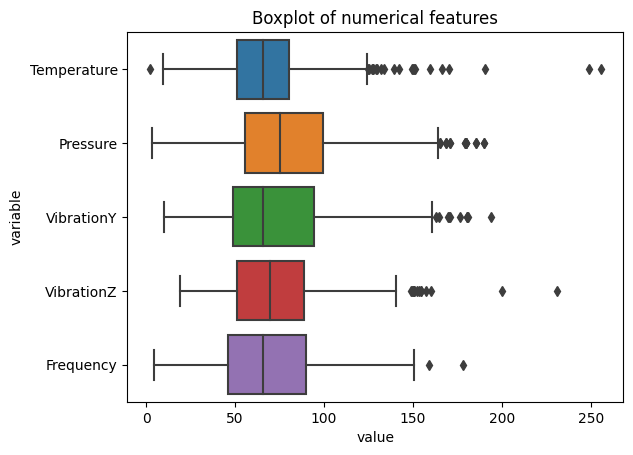

In [56]:
# Box plot

sns.boxplot(data=pd.melt(df[NUM_FEATURE_COLS]), 
              x="value",
              y="variable",
              orient='h')

plt.title('Boxplot of numerical features')

**Conclusions:**

- Dataset hasn't missing values
- All numeric variables are in a similar scale
- All numeric variables have superiors outliers
- Variable `Temperature` have inferior outliers



#### 2.1. Calculate how many times the equipment has failed

In [20]:
df['Fail'].value_counts()

Fail
False    734
True      66
Name: count, dtype: int64

In [21]:
df['Fail'].value_counts(normalize=True)

Fail
False    0.9175
True     0.0825
Name: proportion, dtype: float64

**Conclusion:** 

The equipment has failed by 66 times of 800 cycles. This represent a failure rate of 8.25%.

**2.2 Categorize equipment failures by setups configurations (preset 1 and preset 2)**

This point will be treated at two steps:

- Fisrt, we'll check the failure rate by setup configurations individually
- After, we'll check the effect of combining the two setups


In [203]:
# Function: 
#           plot the failure rate by preset on horizontal 
#           bar plot with percentage format/

def plot_failure_by_preset(df:pd.DataFrame,
                           ax:plt.axes, 
                           preset_col:str,
                           target_col:str = TARGET_COL, 
                           return_result_df:bool = True):

    ps_df = df[[preset_col, target_col]] \
                .groupby(preset_col) \
                .agg({target_col: 'mean'}) \
                .reset_index() \
                .sort_values(by=target_col)

    ps_df['Failure_Rate'] = ps_df[target_col] \
                            .apply(lambda x: x*100)

    labels = ps_df['Failure_Rate'].round(2).astype('str') + '%'
    ps_df.plot.barh(x=preset_col, y='Failure_Rate', legend=False, ax=ax);

    max_x = int(ps_df['Failure_Rate'].max()) + 2

    for container in ax.containers:
        ax.bar_label(container, labels=labels)
        ax.xaxis.set_major_formatter(mtick.PercentFormatter())  
        
    ax.set_xlim((0, max_x))
    
    ax.set_title(f'Failure Rate for {preset_col}');

    if return_result_df:
        ps_df['Failure_Rate'] = ps_df[target_col]
        return ax, ps_df.drop(target_col, axis=1)
    else:
        return ax


For individually setups `Preset1` and `Preset2`

Text(0.5, 0.98, 'Individualy failure rates by Preset 1 and Preset 2')

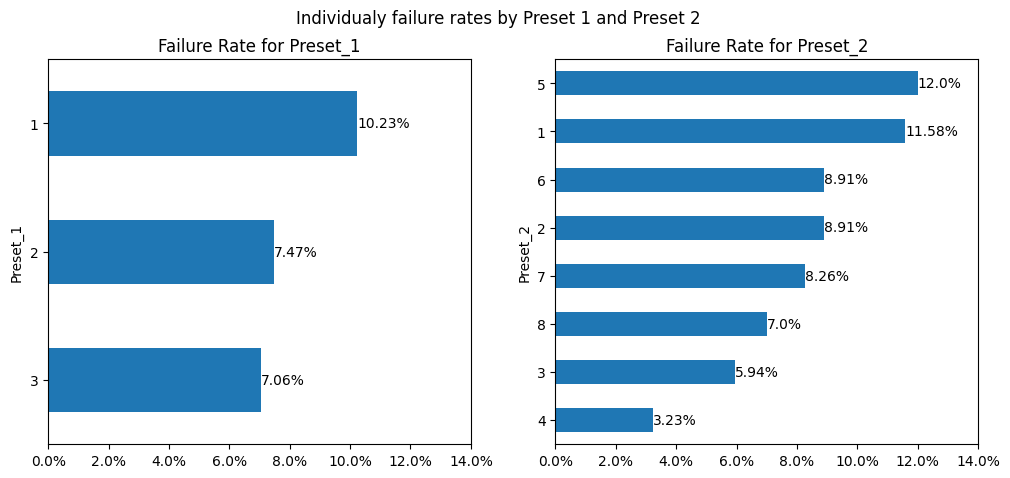

In [204]:
# Creating subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False, sharex=True)

# Preset 1
ax1, ps1_df = plot_failure_by_preset(df, ax1, PRESET_COLS[0], TARGET_COL)

# Preset 2
ax2, ps2_df = plot_failure_by_preset(df, ax2, PRESET_COLS[1], TARGET_COL)


# Combining the plots
fig.suptitle('Individualy failure rates by Preset 1 and Preset 2')

Combining the presets: now we have a comparision of 24 possibles combinations envonvilng `Preset1` (3 possibilities) and `Preset2` (8 possibilities).

For label these combinations, we'll create a new column named as `Combined_Presets` with the code generated by  `<Preset1 value>_<Preset2 value>` - for example, if `Preset1` has the value 2 and `Preset1` has the value 7, the variable `Combined_Presets` will have the label `2_7`.

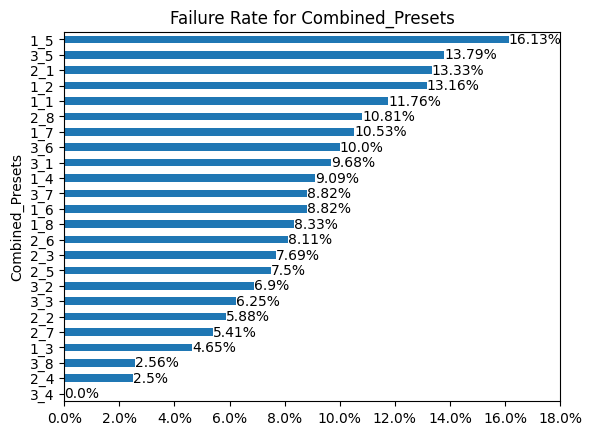

In [205]:
# Creating a auxiliary dataframe
aux_df = df.copy()

# Add a column with the combinations of configuration setups
aux_df['Combined_Presets'] = [str(ps1) + '_' + str(ps2) \
                              for ps1, ps2 in zip(aux_df[PRESET_COLS[0]],
                                                  aux_df[PRESET_COLS[1]])]

# Using the same function to plot
ax3 = plt.axes()
ax3, ps_df = plot_failure_by_preset(aux_df, ax3, 'Combined_Presets', TARGET_COL)

For a proper analysis, I'll use quantiles to classifier the failure rates inside tree categories:

- Failure rate below Q1 (0.25): label `low`
- Failure rate between Q1 (0.25) and Q3 (0.75): label `moderated`
- Failure rate over Q3 (0.75): label `high`

I'll keep that information at variable `setup_failure_rate` on DataFrame `ps_df` (returned by plot function).

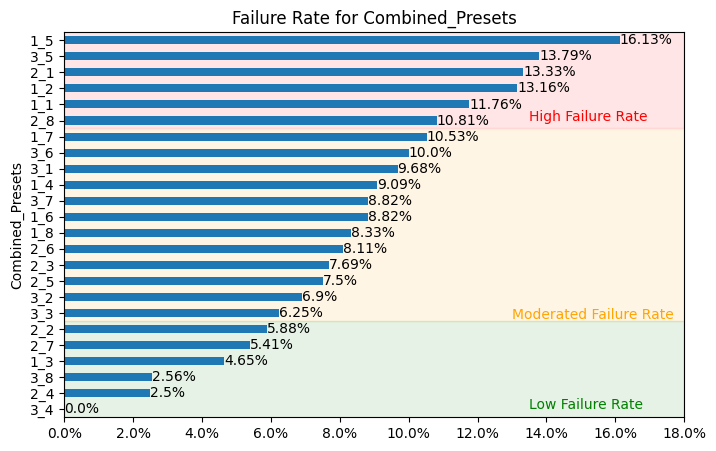

In [206]:
# Get bins (used in plot)
_, bins = pd.qcut(ps_df['Failure_Rate'], [0, .25, .75, 1.], retbins=True)

# Create new axes
fig, ax4 = plt.subplots(1, 1, figsize=(8, 5), sharey=True, sharex=True)
# ax4 = plt.axes()

# Add regions to plot
ax4.axhspan(-1, 5.5, color='green', alpha=0.1)
ax4.axhspan(5.51, 17.5, color='orange', alpha=0.1)
ax4.axhspan(17.51, 30, color='red', alpha=0.1)

ax4.annotate("Low Failure Rate", (13.5, 0), color='green')
ax4.annotate("Moderated Failure Rate", (13, 5.6), color='orange')
ax4.annotate("High Failure Rate", (13.5, 18), color='red')

# Show Plot 
ax4, ps_df = plot_failure_by_preset(aux_df, ax4, 'Combined_Presets', TARGET_COL)

# Add labels to DataFrame
ps_df['setup_failure_rate'] = pd.qcut(ps_df['Failure_Rate'],
                                      [0, .25, .75, 1.], 
                                      labels=['low', 'moderated', 'high'])


**Conclusions:**

- Failure rate tends to be higher when `Preset1` assumes value 3;
- Failure rate tends to be higher when `Preset2` assumes values 5 or 1;
- Looking at the `Preset1` and `Preset2` combinations, we can conclude:
    * Combinations with high failure rates:            
            <table>
            <tbody>
            <tr>
            <td>&nbsp;Preset1</td>
            <td>Preset2</td>
            <td>Failure Rate</td>
            </tr>
            <tr>
            <td>1</td>
            <td>5</td>
            <td>16.13%</td>
            </tr>
            <tr>
            <td>3</td>
            <td>5</td>
            <td>13.79%</td>
            </tr>
            <tr>
            <td>2</td>
            <td>1</td>
            <td>13.33%</td>
            </tr>
            <tr>
            <td>1</td>
            <td>2</td>
            <td>13.16%</td>
            </tr>
            <tr>
            <td>1</td>
            <td>1</td>
            <td>11.76%</td>
            </tr>
            <tr>
            <td>2</td>
            <td>8</td>
            <td>10.81%</td>
            </tr>
            </tbody>
            </table>
            <!-- DivTable.com -->

    * Combinations with lower failure rates:
        <table>
        <tbody>
        <tr style="height: 23px;">
        <td style="height: 23px;">&nbsp;Preset1</td>
        <td style="height: 23px;">Preset2</td>
        <td style="height: 23px;">Failure Rate</td>
        </tr>
        <tr style="height: 23px;">
        <td style="height: 23px;">2</td>
        <td style="height: 23px;">2</td>
        <td style="height: 23px;">5.88%</td>
        </tr>
        <tr style="height: 23px;">
        <td style="height: 23px;">2</td>
        <td style="height: 23px;">7</td>
        <td style="height: 23px;">5.41%</td>
        </tr>
        <tr style="height: 23px;">
        <td style="height: 23px;">1</td>
        <td style="height: 23px;">3</td>
        <td style="height: 23px;">4.65%</td>
        </tr>
        <tr style="height: 23px;">
        <td style="height: 23px;">3</td>
        <td style="height: 23px;">8</td>
        <td style="height: 23px;">2.56%</td>
        </tr>
        <tr style="height: 23px;">
        <td style="height: 23px;">2</td>
        <td style="height: 23px;">4</td>
        <td style="height: 23px;">2.5%</td>
        </tr>
        <tr style="height: 23px;">
        <td style="height: 23px;">3</td>
        <td style="height: 23px;">4</td>
        <td style="height: 23px;">0.00%</td>
        </tr>
        </tbody>
        </table>
        <!-- DivTable.com -->


**2.3 Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others)**

For given that information, we have to look for data distributions for cases of failures and not failures. Here we can use box plot one more time!

Text(0.5, 1.0, 'Parameters Distributions: failures and not failures')

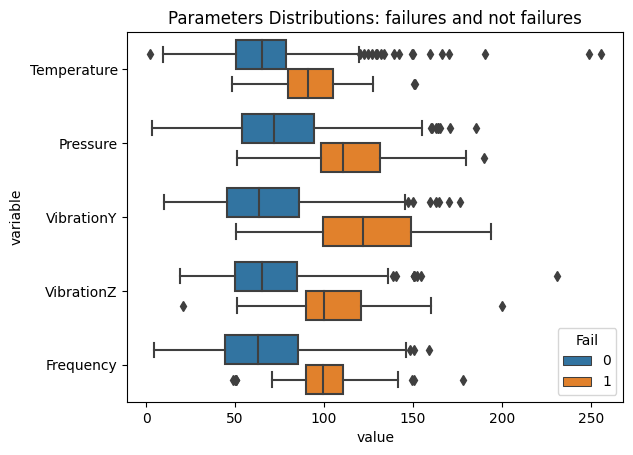

In [212]:
sns.boxplot(data=df.melt(id_vars=TARGET_COL, value_vars=NUM_FEATURE_COLS), 
            y='variable',
            x='value',
            hue=TARGET_COL,
            orient='h')

plt.title('Parameters Distributions: failures and not failures')

Looking for the plot above, we can cleary see that all parameters presents higher values for failure cases. 

On the table bellow, we can see some differences about distribution categorization for these parameters in cases of non-failures and failures. 

In [224]:
def q1(x): return x.quantile(0.25)

def q3(x): return x.quantile(0.75)

aggregations = {c: ['count', 'mean', 'std', 'median', 'min', q1, 'median', q3, 'max'] \
                for c in NUM_FEATURE_COLS}

aux_df = df.groupby(TARGET_COL).agg(aggregations).T
aux_df.columns = ['Non-Failure', 'Failure']

aux_df

Non-Failure     Failure
Temperature count    734.000000   66.000000
            mean      67.176884   92.469125
            std       24.824880   21.683670
            median    64.814877   90.928964
            min        2.089354   48.091962
            q1        50.471831   79.784598
            median    64.814877   90.928964
            q3        78.362952  104.960599
            max      255.607829  150.880308
Pressure    count    734.000000   66.000000
            mean      75.632790  116.422540
            std       30.561615   30.040055
            median    71.911241  110.619156
            min        3.480279   50.822002
            q1        53.709124   98.283167
            median    71.911241  110.619156
            q3        94.557459  131.353569
            max      185.406401  189.995681
VibrationY  count    734.000000   66.000000
            mean      68.318455  122.481159
            std       29.010220   30.861777
            median    63.516837  122.115118
            min       10.057744   50.481820
            q1        45.626713   99.473948
            median    63.516837  122.115118
            q3        85.849744  148.611903
            max      176.197917  193.569947
VibrationZ  count    734.000000   66.000000
            mean      68.796672  106.003200
            std       25.678027   28.377486
            median    65.005965   99.669357
            min       18.784169   20.522642
            q1        50.108618   89.873117
            median    65.005965   99.669357
            q3        84.551724  120.635254
            max      230.951134  200.242674
Frequency   count    734.000000   66.000000
            mean      65.382995   99.812745
            std       27.943436   22.960578
            median    62.687313   99.212676
            min        4.380101   48.923777
            q1        44.516991   89.974024
            median    62.687313   99.212676
            q3        85.218644  110.702196
            max      158.811673  178.090303

In order to have a proprely comparision about these diferences on parameter's data distributions, a statistical test is required. For that data, we use the **t-test** with the null hypotesis that the two distributions (failure and non-failure) are statisticaly equal in a confidence interval - We can reject the null hypotesis if the p-value provided by the test are fewer than 0.05.

In [232]:
for c in NUM_FEATURE_COLS:

    dist_0 = df.loc[df[TARGET_COL]==0, c].values
    dist_1 = df.loc[df[TARGET_COL]==1, c].values

    t_stat, p_val =  ttest_ind(dist_1, dist_0)

    spaces_1 = " " * (15 - len(c))
    spaces_2 = " " * (4 - len(str(int(t_stat))))

    print(c + spaces_1 + '|    t-statistic: {:.2f}'.format(t_stat) + \
          spaces_2 + '| p-value: {:.4f}'.format(p_val))

Temperature    |    t-statistic: 8.01   | p-value: 0.0000
Pressure       |    t-statistic: 10.40  | p-value: 0.0000
Pressure       |    t-statistic: 10.40  | p-value: 0.0000
VibrationY     |    t-statistic: 14.45  | p-value: 0.0000
VibrationZ     |    t-statistic: 11.18  | p-value: 0.0000
Frequency      |    t-statistic: 9.72   | p-value: 0.0000


**Conclusion:** With this statistical test, we can conclude that have significative difference between cases os failure and non-failure for all parameters values.